In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import pickle
import os

from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra, connected_components
from itertools import chain, combinations, product

from reeb_graph import Reeb_Graph
from reeb_aux import *

In [2]:
import networkx as nx
import pyomo.environ as pyo
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)


def circular_max_flow(reeb):
    
    edges = reeb.E+1
    
    pts_bottom = np.unique(reeb.REEB_GRAPH[:,0])
    pts_bottom = pts_bottom[pts_bottom>-1]
    pts_top = np.unique(reeb.REEB_GRAPH[:,-1])
    pts_top = pts_top[pts_top>-1]
    
    add_edges_bottom = np.vstack([np.zeros_like(pts_bottom),pts_bottom + 1]).T
    add_edges_top = np.vstack([pts_top + 1, np.zeros_like(pts_top) + np.max(reeb.G.nodes) + 2]).T
    
    constr_edges = np.zeros((len(add_edges_bottom),4))
#    constr_edges = np.hstack([add_edges_bottom, add_edges_top])
    constr_edges[:,:2] = add_edges_bottom
    constr_edges[:,2:] = add_edges_top
    
    edges = np.vstack([add_edges_bottom,edges,add_edges_top])
    edges_to_idx = {}

    for e in edges:
        edges_to_idx[tuple(e)] = np.argmin(np.linalg.norm(edges-e,axis=-1)) 
        
    N = np.sum(reeb.D_reeb_w)
    cap = {}
    
    for e in reeb.E:
        cap[tuple(e+1)] = reeb.G.edges[tuple(e)]['capacity']
        
    for e in add_edges_bottom:
        cap[tuple(e)] = N
    
    for e in add_edges_top:
        cap[tuple(e)] = N
    
    cost = pyo.ConcreteModel()
    cost.n = len(edges) 

    cost.f = pyo.Var(np.arange(cost.n),
                     domain=pyo.NonNegativeReals,initialize=0)
    
    flow = sum([cost.f[edges_to_idx[(0,v+1)]] for v in pts_bottom]) 

    cost.obj=pyo.Objective(rule=flow, sense=pyo.maximize)
    cost.costr=pyo.ConstraintList()

    for e in edges:
        cost.costr.add(cost.f[edges_to_idx[tuple(e)]] <= cap[tuple(e)])

    for e in constr_edges:
        cost.costr.add(cost.f[edges_to_idx[tuple(e[:2])]] == cost.f[edges_to_idx[tuple(e[2:])]])


    for v in list(reeb.G.nodes):
        
        neigh = list(reeb.G[v])
        
        if v in pts_bottom:
            neigh = neigh+[-1]  
        elif v in pts_top:
            neigh = neigh+[np.max(reeb.G.nodes) + 1]  
            
        if len(neigh)>0:
            flx_in = sum([cost.f[edges_to_idx[(u+1,v+1)]] for u in neigh if u<v])
            flx_out = sum([cost.f[edges_to_idx[(v+1,u+1)]] for u in neigh if u>v])
            cost.costr.add(flx_in-flx_out==0)

    solver = pyo.SolverFactory('gurobi')
    S=solver.solve(cost)

    flx = cost.obj()

    f_eval = np.zeros_like(edges[:,0])

    for key,val in cost.f.extract_values().items():
                f_eval[key]=val 

    flow_eval = np.sum([f_eval[edges_to_idx[(0,v+1)]] for v in pts_bottom]) 
    
    return flow_eval

In [3]:
np.random.seed(17051991)

In [4]:
def poisson(lam,dim=3):
    
    n = np.random.poisson(lam=lam, size=(1,))[0]
    X = np.random.uniform(low=0.0, high=1.0, size=(n,dim))
    
    return X


def matern_rep(lam,R,dim=3):

    n = np.random.poisson(lam=lam, size=(1,))[0]
    X = np.random.uniform(low=0.0, high=1.0, size=(n,dim))
    t = np.random.uniform(low=0.0, high=1.0, size=(n,))
    
    D = squareform(pdist(X))
    
    order = np.argsort(t)
    
    idxs = np.ones_like(order)
    
    for i in order:
        if idxs[i]>0:
            idxs_aux_0 = D[i,:]<R 
            idxs_aux_1 = np.zeros_like(order)
            idxs_aux_1[i+1:] = 1
            
            idxs_aux = idxs_aux_0*idxs_aux_1
            
            idxs = idxs - idxs_aux
    
    idxs = idxs>0
    
    return X[idxs,:]


def matern_clust(lam_1,lam_2,R,dim=3):

    n = np.random.poisson(lam=lam_1, size=(1,))[0]
    P = np.random.uniform(low=0.0, high=1.0, size=(n,dim))
      
    p = P[0,:]
    n_p = np.random.poisson(lam=lam_2, size=(1,))[0]
    X = p+np.random.uniform(low=0.0, high=R, size=(n_p,dim))
    
    for p in P:
        n_p = np.random.poisson(lam=lam_2, size=(1,))[0]
        X_p = p+np.random.uniform(low=0.0, high=R, size=(n_p,dim))
        X = np.vstack([X,X_p])
        
    return X

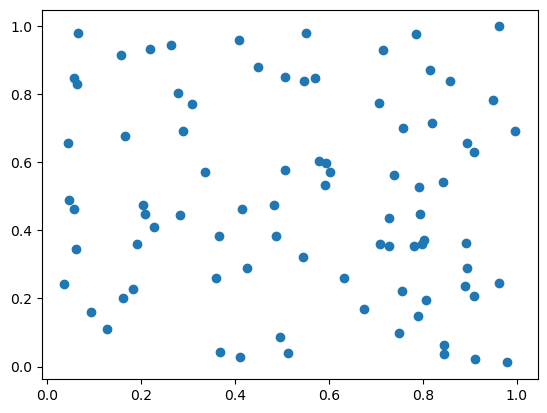

In [5]:
X = poisson(100,dim=2)

plt.scatter(X[:,0],X[:,1])

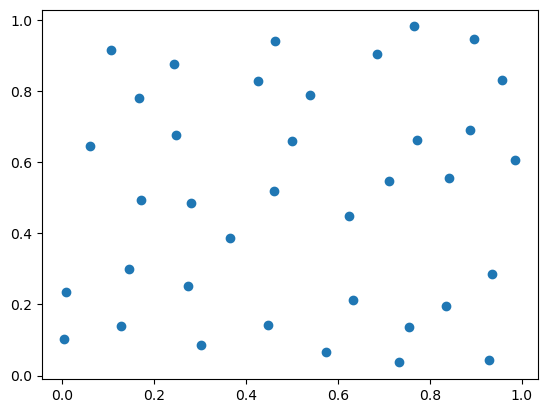

In [6]:
X = matern_rep(100,0.1,dim=2)

plt.scatter(X[:,0],X[:,1])

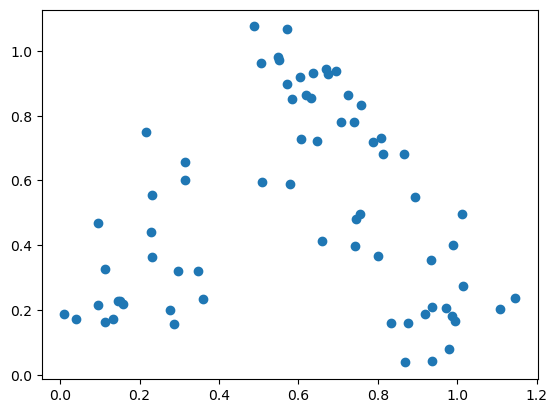

In [12]:
X = matern_clust(20,5,0.2,dim=2)

plt.scatter(X[:,0],X[:,1])

In [17]:
for _ in range(20):
    X = matern_rep(400,0.1)
    print(X.shape[0])

227
199
229
230
235
239
224
219
225
229
224
202
238
233
225
219
231
209
221
206


In [8]:
n_grid = 101
fat = 1
covering = np.array([-1,1])
reeb_stride = 2
relax = [n_grid//2,-(n_grid//2+1)]
stride = 20

M = np.array([1,1,1],dtype=float)
m = np.array([0,0,0],dtype=float)

lam = 100

Ho fallito:  0 0 33eration: 0 Class:  0 Grid element:  32        
Ho fallito:  0 0 34eration: 0 Class:  0 Grid element:  33        
Ho fallito:  0 0 35eration: 0 Class:  0 Grid element:  34        
Ho fallito:  0 1 25eration: 0 Class:  1 Grid element:  24        
Ho fallito:  0 1 27eration: 0 Class:  1 Grid element:  26        


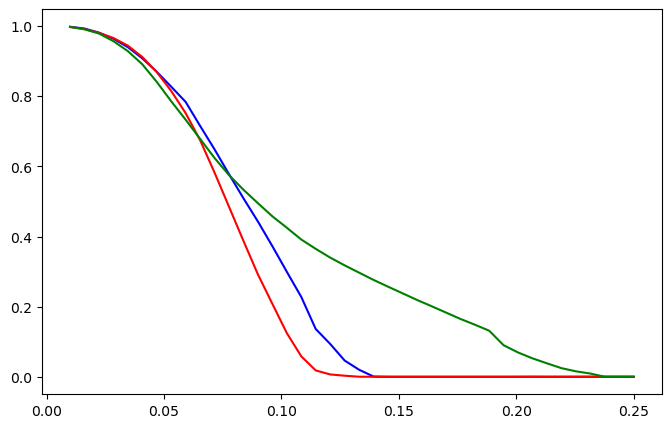

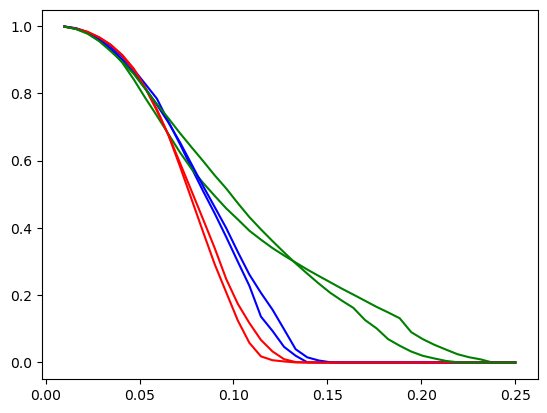

Ho fallito:  2 1 25eration: 2 Class:  1 Grid element:  24        
Ho fallito:  2 1 26eration: 2 Class:  1 Grid element:  25        
Ho fallito:  2 1 28eration: 2 Class:  1 Grid element:  27        


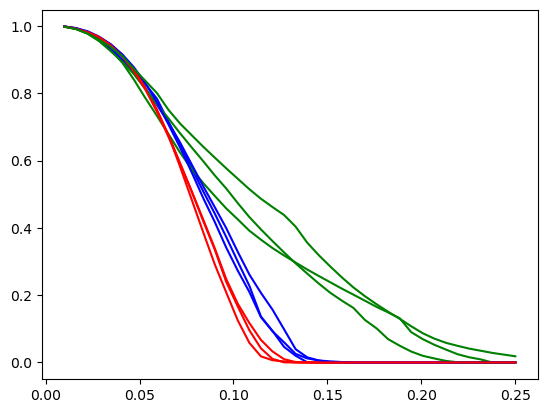

Ho fallito:  3 1 25eration: 3 Class:  1 Grid element:  24        
Ho fallito:  3 2 39eration: 3 Class:  2 Grid element:  38        


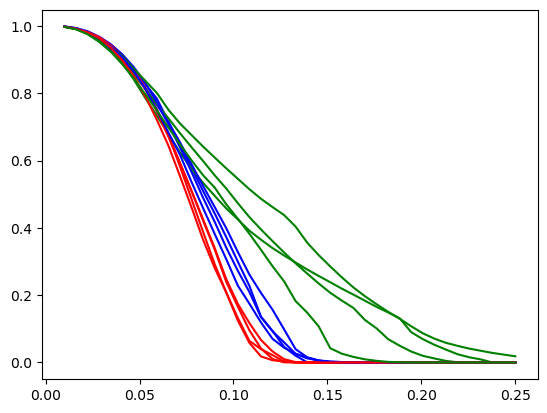

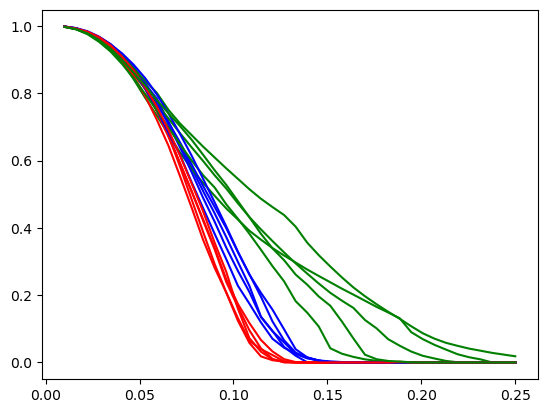

Ho fallito:  5 1 27eration: 5 Class:  1 Grid element:  26        


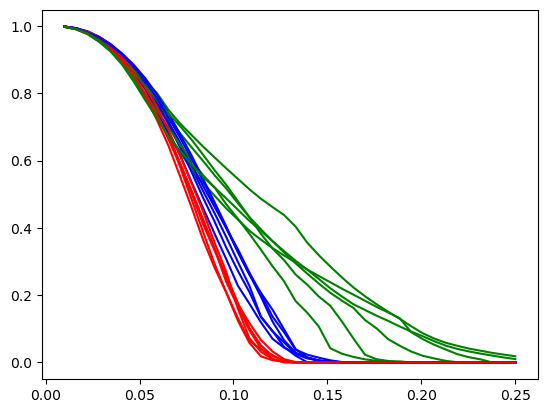

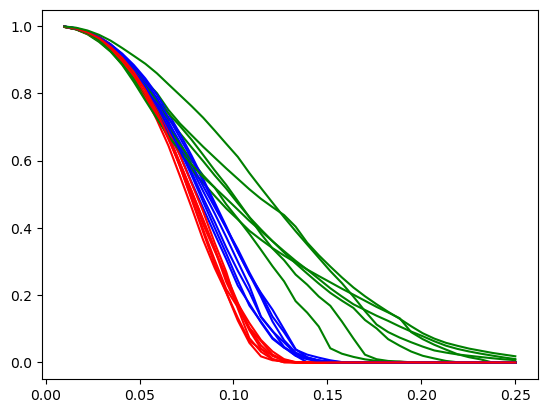

Ho fallito:  7 0 30eration: 7 Class:  0 Grid element:  29        
Ho fallito:  7 0 31eration: 7 Class:  0 Grid element:  30        
Ho fallito:  7 0 32eration: 7 Class:  0 Grid element:  31        


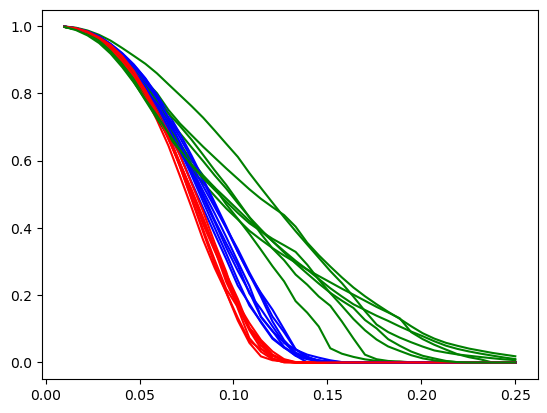

Ho fallito:  8 0 29eration: 8 Class:  0 Grid element:  28        


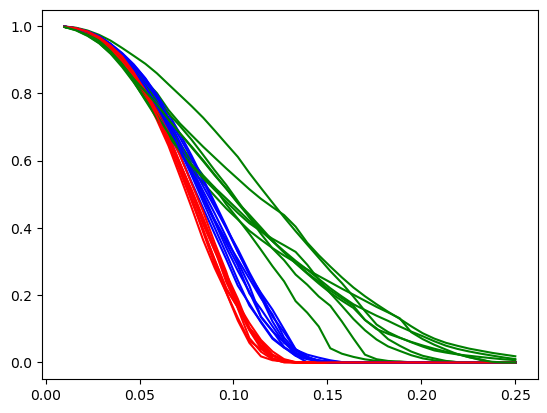

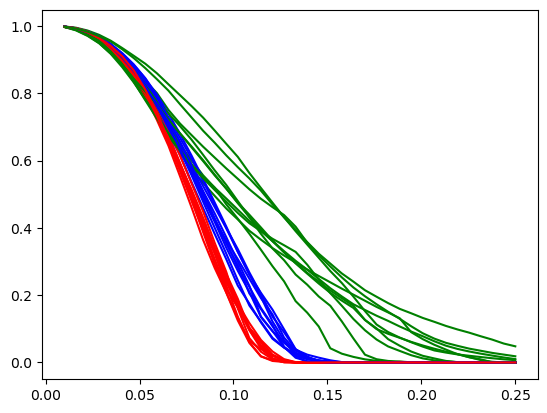

Ho fallito:  10 1 31ration: 10 Class:  1 Grid element:  30        


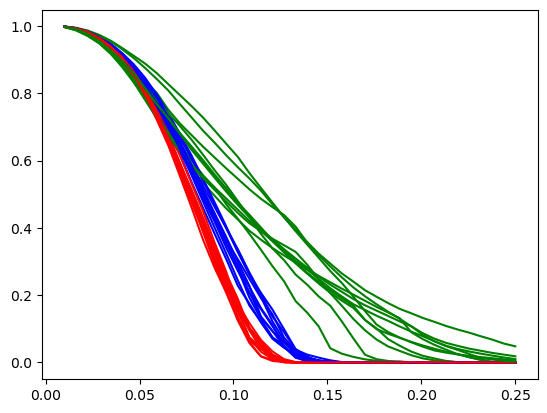

Ho fallito:  11 0 38ration: 11 Class:  0 Grid element:  37        


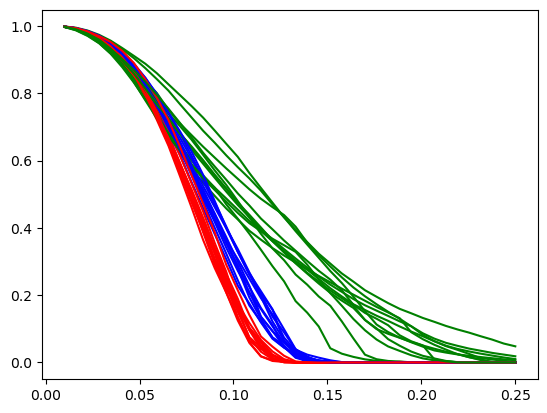

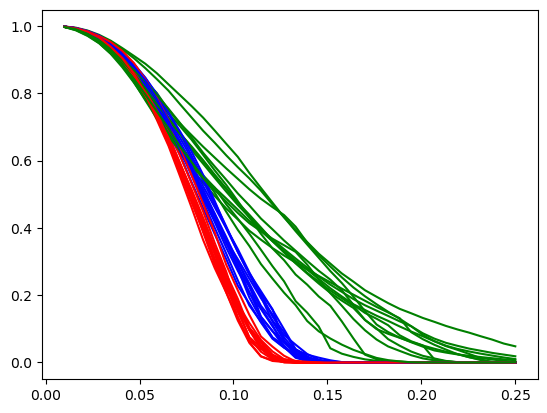

Ho fallito:  13 0 32ration: 13 Class:  0 Grid element:  31        
Ho fallito:  13 0 33ration: 13 Class:  0 Grid element:  32        
Ho fallito:  13 1 28ration: 13 Class:  1 Grid element:  27        


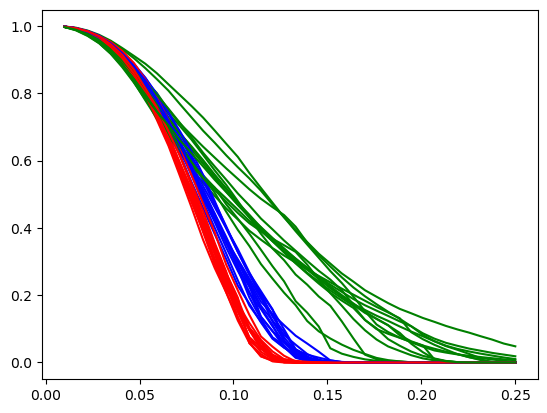

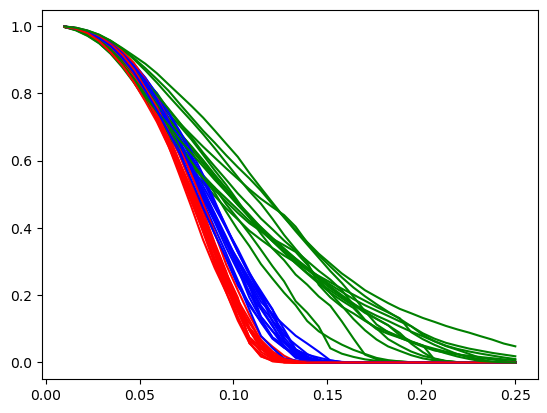

Ho fallito:  15 0 32ration: 15 Class:  0 Grid element:  31        
Ho fallito:  15 1 25ration: 15 Class:  1 Grid element:  24        


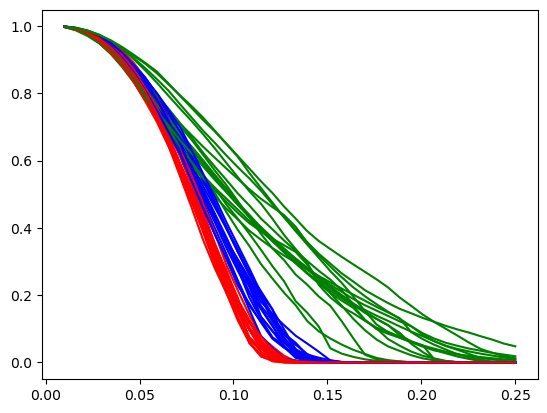

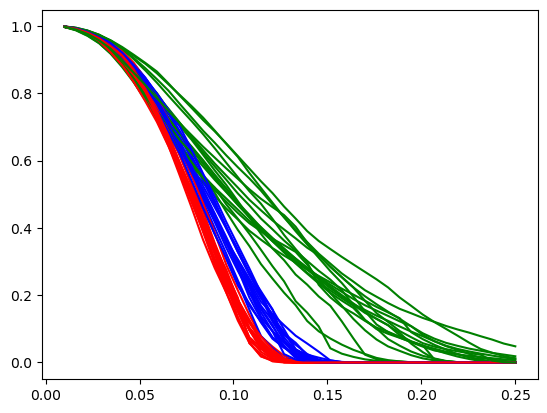

Ho fallito:  17 0 28ration: 17 Class:  0 Grid element:  27        
Ho fallito:  17 0 31ration: 17 Class:  0 Grid element:  30        
Ho fallito:  17 1 27ration: 17 Class:  1 Grid element:  26        
Ho fallito:  17 1 28ration: 17 Class:  1 Grid element:  27        


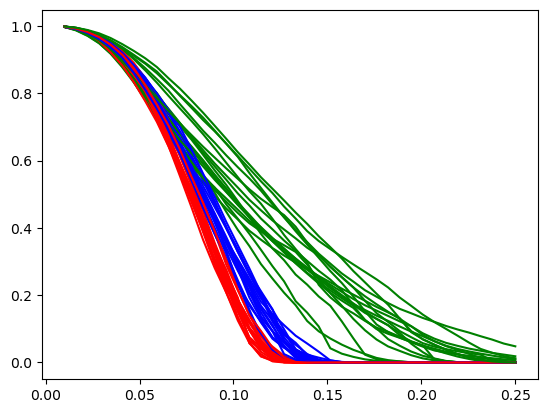

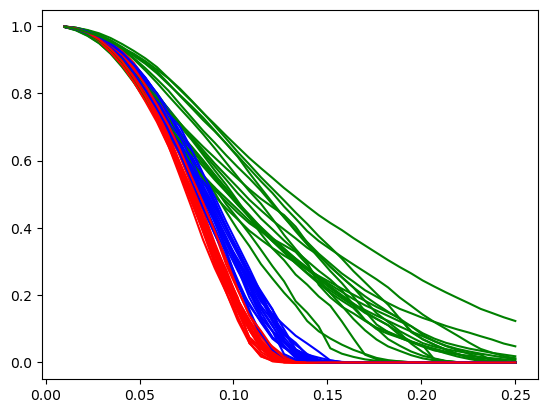

Ho fallito:  19 0 31ration: 19 Class:  0 Grid element:  30        


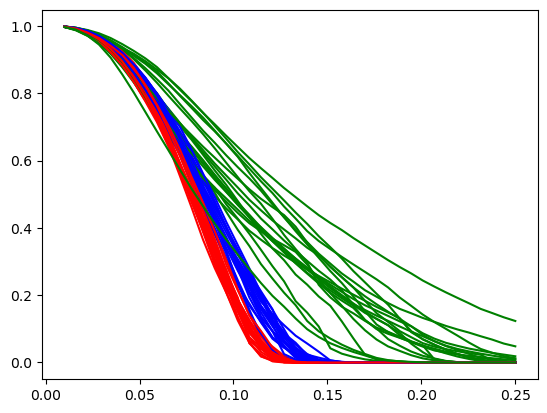

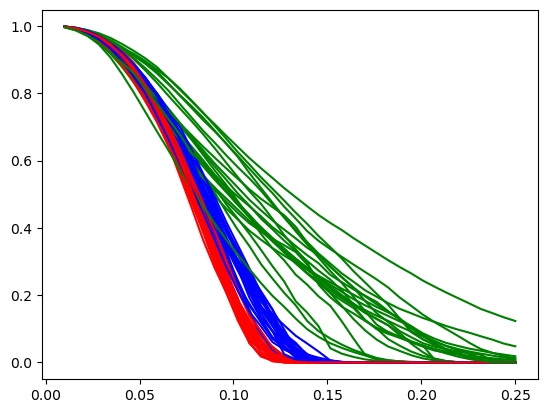

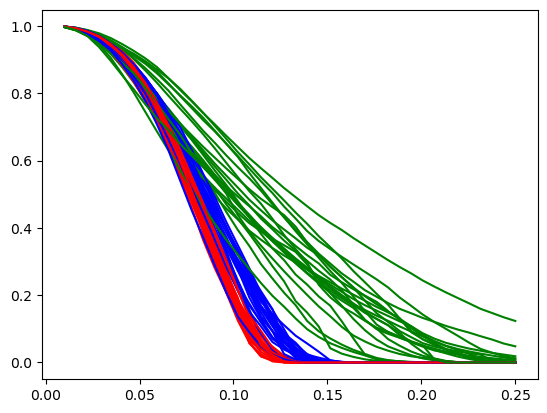

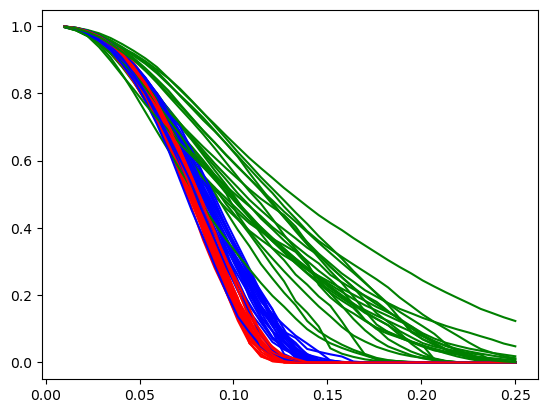

Ho fallito:  23 0 35ration: 23 Class:  0 Grid element:  34        


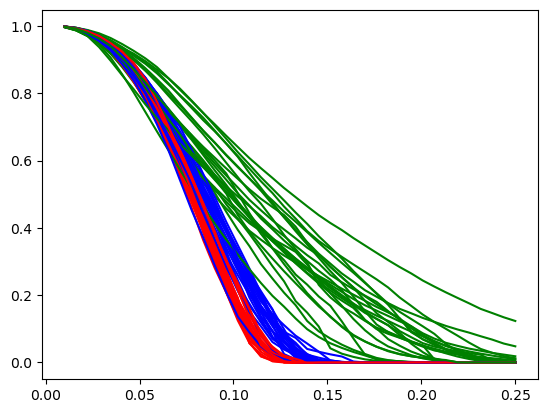

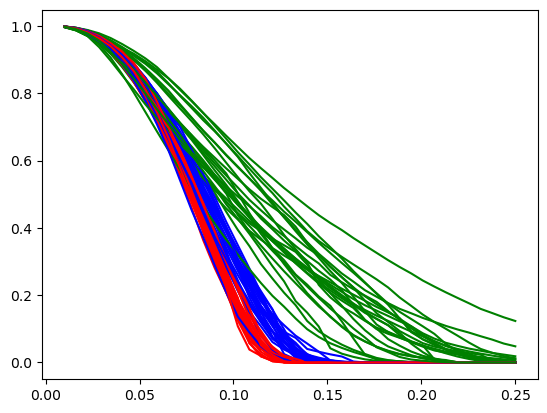

Ho fallito:  25 0 28ration: 25 Class:  0 Grid element:  27        
Ho fallito:  25 2 37ration: 25 Class:  2 Grid element:  36        
Ho fallito:  25 2 38ration: 25 Class:  2 Grid element:  37        
Ho fallito:  25 2 39ration: 25 Class:  2 Grid element:  38        


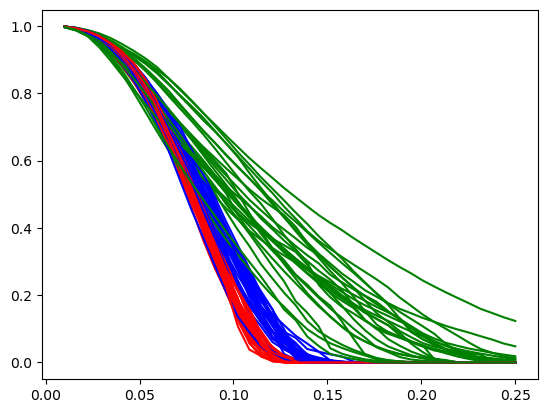

Ho fallito:  26 1 29ration: 26 Class:  1 Grid element:  28        


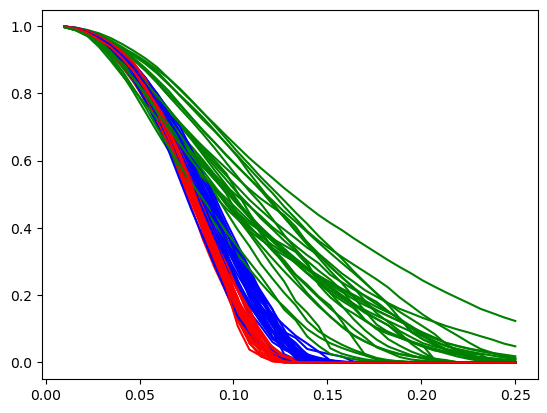

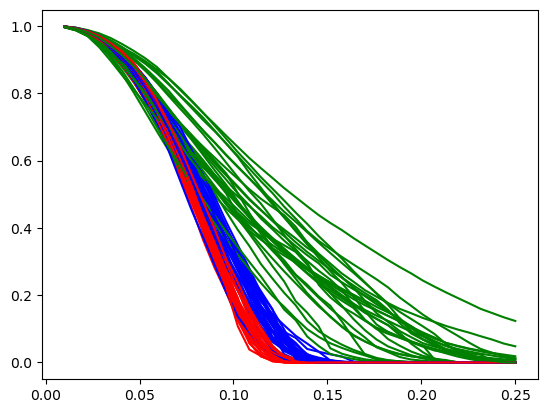

Ho fallito:  28 0 30ration: 28 Class:  0 Grid element:  29        
Ho fallito:  28 1 27ration: 28 Class:  1 Grid element:  26        
Ho fallito:  28 1 31ration: 28 Class:  1 Grid element:  30        
Ho fallito:  28 1 32ration: 28 Class:  1 Grid element:  31        


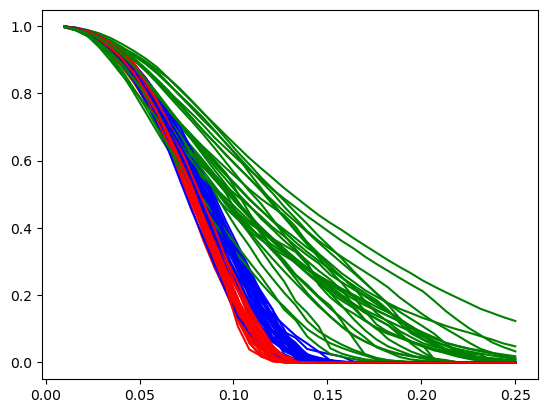

Ho fallito:  29 1 26ration: 29 Class:  1 Grid element:  25        


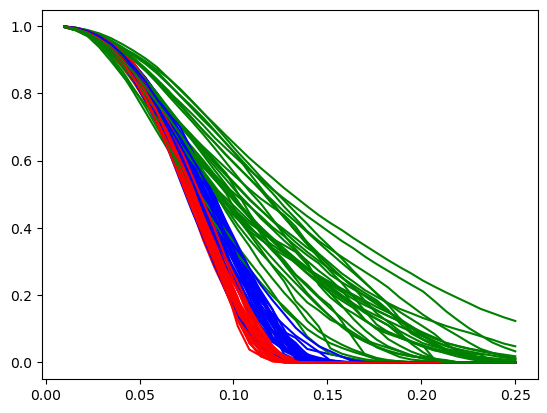

Ho fallito:  30 1 24ration: 30 Class:  1 Grid element:  23        


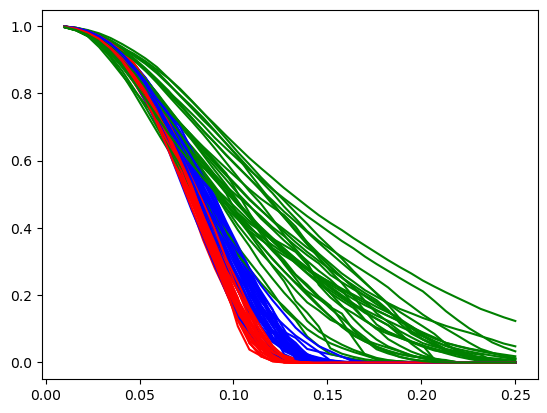

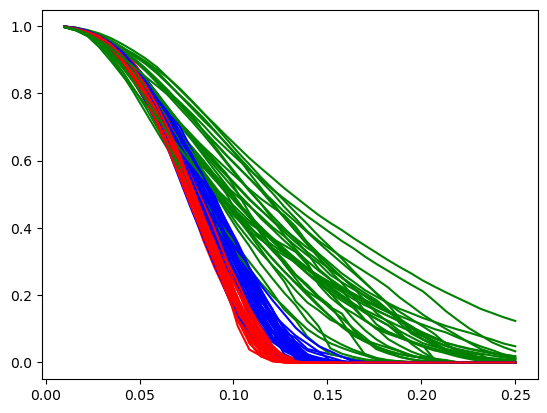

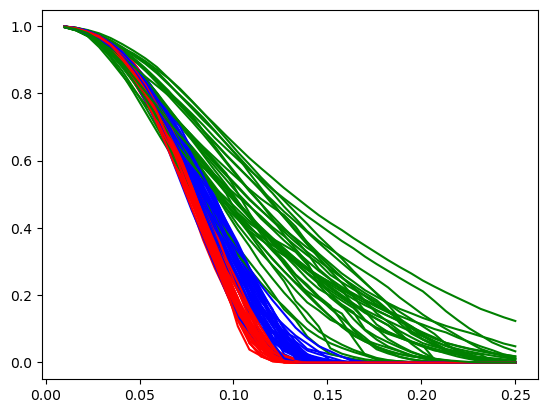

Ho fallito:  33 0 30ration: 33 Class:  0 Grid element:  29        
Ho fallito:  33 1 28ration: 33 Class:  1 Grid element:  27        


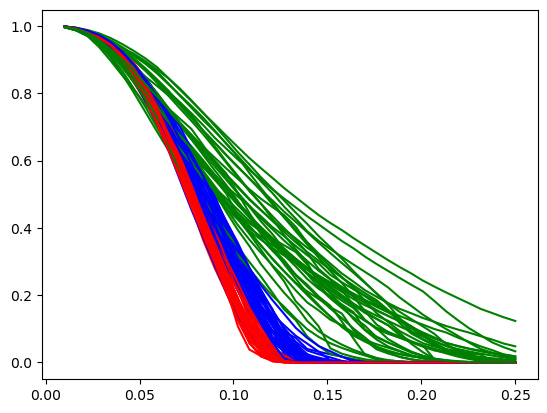

Ho fallito:  34 0 32ration: 34 Class:  0 Grid element:  31        


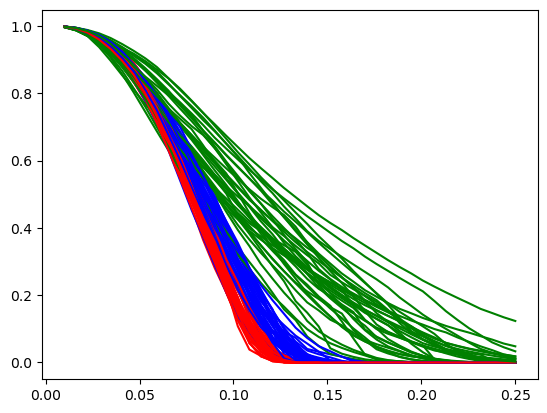

Ho fallito:  35 0 31ration: 35 Class:  0 Grid element:  30        
Ho fallito:  35 0 32ration: 35 Class:  0 Grid element:  31        
Ho fallito:  35 1 25ration: 35 Class:  1 Grid element:  24        


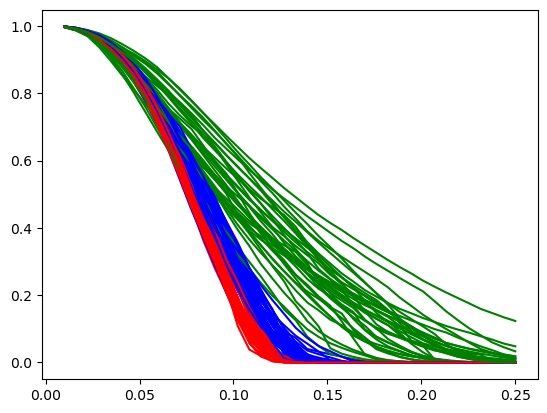

Ho fallito:  36 1 25ration: 36 Class:  1 Grid element:  24        


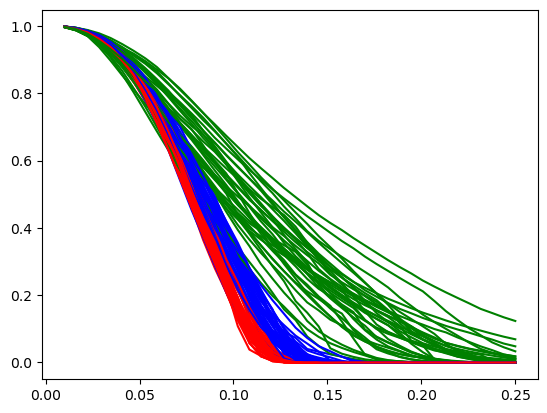

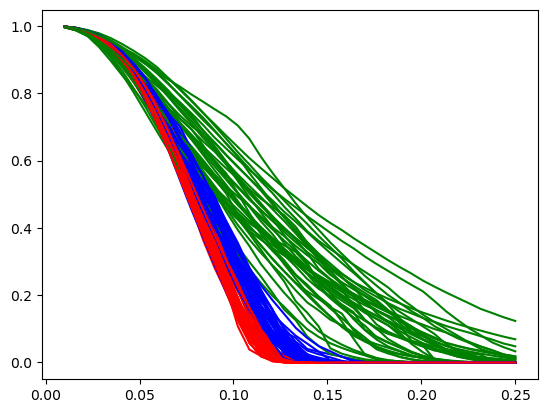

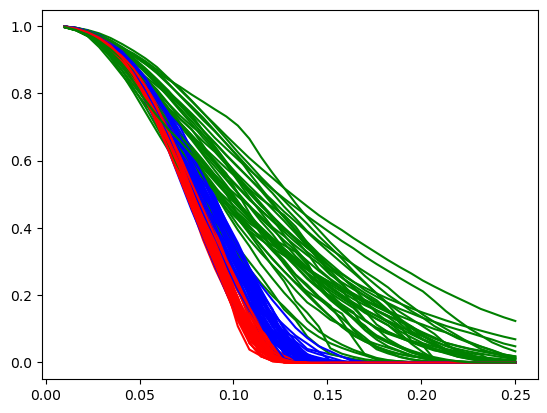

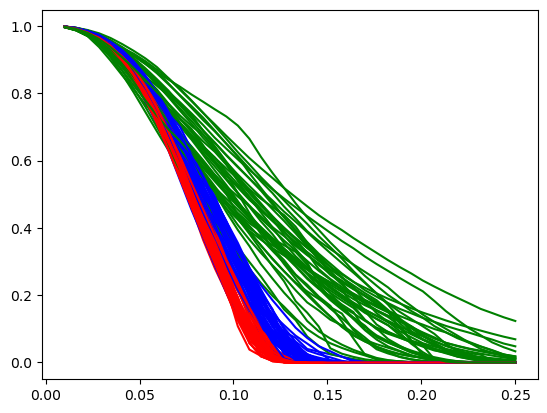

Ho fallito:  40 0 31ration: 40 Class:  0 Grid element:  30        


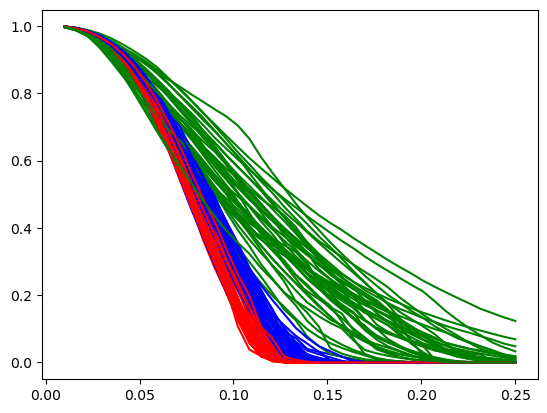

Ho fallito:  41 0 32ration: 41 Class:  0 Grid element:  31        
Ho fallito:  41 1 27ration: 41 Class:  1 Grid element:  26        


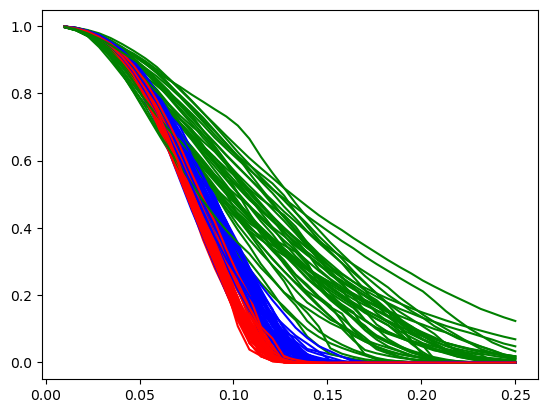

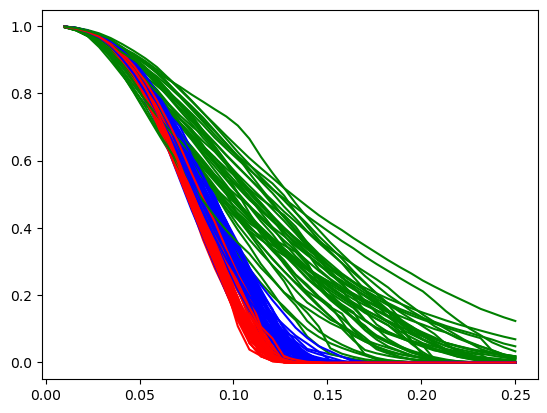

Ho fallito:  43 0 29ration: 43 Class:  0 Grid element:  28        
Ho fallito:  43 0 31ration: 43 Class:  0 Grid element:  30        
Ho fallito:  43 0 32ration: 43 Class:  0 Grid element:  31        


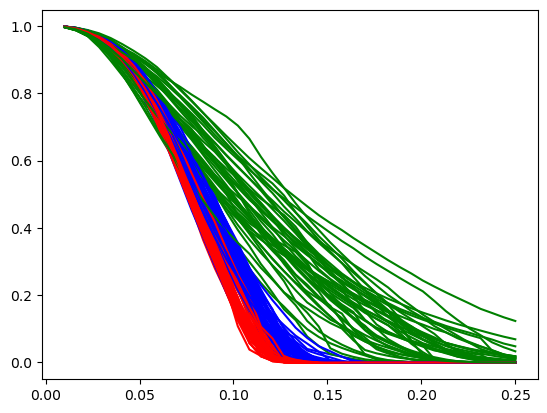

KeyboardInterrupt: 

In [18]:
F = []
colors = ['b','r','g']
labels = ['CSR','Repulsive','Cluster']
r_grid = np.linspace(0.01,0.25,40)


plt.ion()
figure, ax = plt.subplots(figsize=(8, 5))
    
plt.isinteractive()

c = []
        
for count in range(50):
    for i in [0,1,2]:

        f = np.zeros_like(r_grid)

        if i ==0:
            X = poisson(200)
        elif i==1:
            X = matern_rep(400,0.1)
        else:
            X = matern_clust(20,10,0.2)

        radii = np.ones_like(X[:,0])

        for j,k in enumerate(r_grid):

            r = radii*k 

            reeb = Reeb_Graph(X, M = M, m = m, radii = r,
                grid_size = n_grid, 
                periodic = True,
                fat_radius = fat,
                covering = covering,
                reeb_stride = reeb_stride,
                transform_points = None,
                relax_z_axis = relax,
                verbose = False, save_RAM = True, stride=stride, MP=False)

            if reeb.res_grid is not None:
                reeb.make_reeb_graph(plot=False)
                try:
                    flow = circular_max_flow(reeb)*(reeb.unit_2d)
                except:
                    print('Ho fallito: ', count,i,j)
                    flow=0
            else: 
                flow = 0

            print('Reeb Graph Done! Iteration:',count,'Class: ',i,'Grid element: ', j,'       ',end='\r')

            f[j] = flow

        F.append(f)
        c.append(colors[i])
        
    for j,f in enumerate(F):
        plt.plot(r_grid,f,c=c[j])

    plt.show()

In [20]:
np.save('colors',colors)
np.save('F',F)


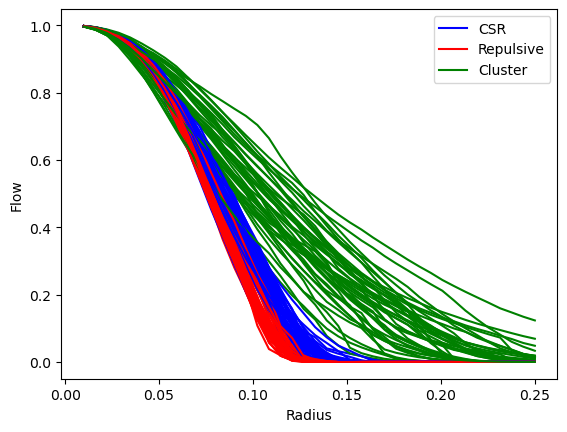

In [19]:
b = 0
r = 0
g = 0

for j,f in enumerate(F):
    
    if b==0 and c[j]=='b':
        plt.plot(r_grid,f,c=c[j], label='CSR')
        b+=1
    elif r==0 and c[j]=='r':
        plt.plot(r_grid,f,c=c[j], label='Repulsive')
        r+=1
    elif g==0 and c[j]=='g':
        plt.plot(r_grid,f,c=c[j], label='Cluster')
        g+=1
    else:    
        plt.plot(r_grid,f,c=c[j])

plt.xlabel('Radius')
plt.ylabel('Flow')
plt.legend()

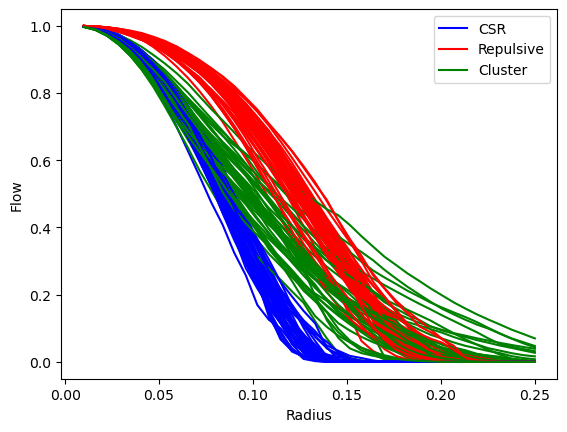

In [14]:
b = 0
r = 0
g = 0

for j,f in enumerate(F):
    
    if b==0 and c[j]=='b':
        plt.plot(r_grid,f,c=c[j], label='CSR')
        b+=1
    elif r==0 and c[j]=='r':
        plt.plot(r_grid,f,c=c[j], label='Repulsive')
        r+=1
    elif g==0 and c[j]=='g':
        plt.plot(r_grid,f,c=c[j], label='Cluster')
        g+=1
    else:    
        plt.plot(r_grid,f,c=c[j])

plt.xlabel('Radius')
plt.ylabel('Flow')
plt.legend()